# Picuris Pueblo, FLIR (thermal-IR) Exploratory Data Analysis
## Samuel Levin, samuel.levin@utdallas.edu
## ------------------------------------------------------------------------------------
### Five flights: Flt0:0530hrs, Flt1:0900hrs, Flt2:1300hrs, Flt3:1630hrs, Flt4:2030hrs
### Data Collected 29 June 2018
### Sprectral Resolution 7.5 - 13.5 µm
### Radiometric Resolution: 14-bit
### Spatial Resolution: 6cm (0.06m)
### Overall Geometric Accuracy: 0.4276 pixels RMSE (0.025656 cm)
## ------------------------------------------------------------------------------------

### Verify python interpreter (with necessary libraries installed), bulk import

In [1]:
import sys
sys.executable

'C:\\Users\\samle\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-pyre\\python.exe'

In [2]:
import arcpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import scipy

### Cast raster as 3 dimensional NumPy array, assign np.nan to NoData pixels

In [3]:
arcpy.env.workspace = r'<PATH/TO/GDB>'

inflir = 'FLIR_Stacked_float'

In [4]:
flir = arcpy.RasterToNumPyArray(inflir, nodata_to_value=np.nan)

In [5]:
flir.shape

(5, 3370, 3779)

In [6]:
flir[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

### Display all 5 original raster bands, 
#### Note varying data extents in each flight

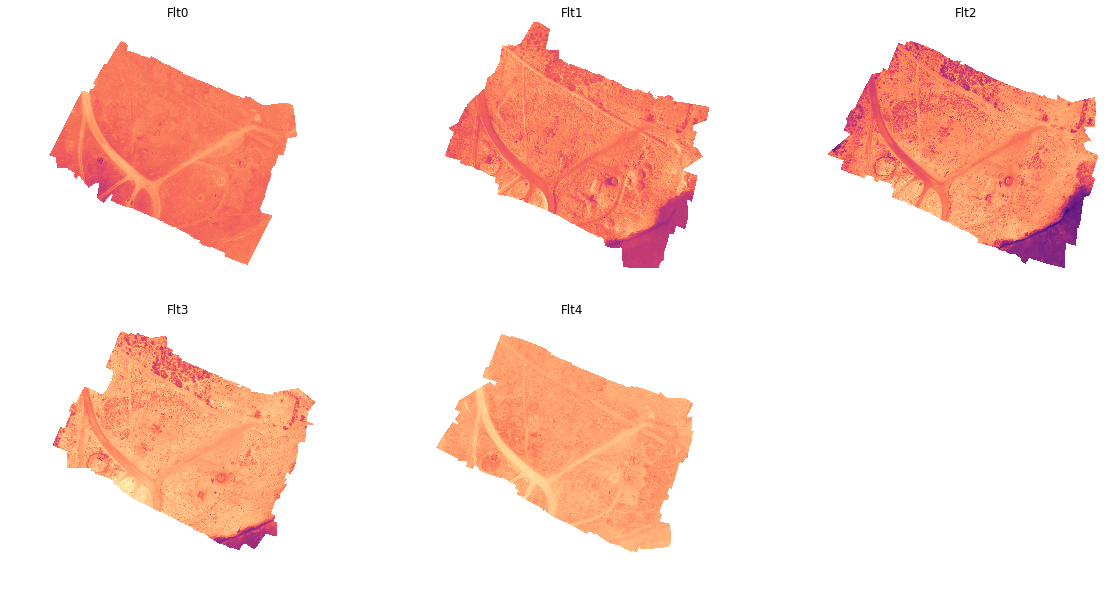

In [7]:
plt.figure(figsize=(20,10))
for band in range(flir.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(flir.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Flt{}'.format(band))
    plt.axis('off')
    plt.imshow(flir[band], cmap='magma')

### Build boolean mask of valid data pixels for all bands in full data extent

In [8]:
np.logical_not(np.isnan(flir[0]))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

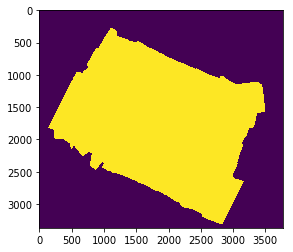

In [9]:
plt.imshow(np.logical_not(np.isnan(flir[0])))

In [10]:
def buildMask(stacked_image):
    individmasks = [np.logical_not(np.isnan(stacked_image[band])) for band in range(stacked_image.shape[0])]
    mask = individmasks[0]
    for im in individmasks:
        mask = np.logical_and(mask, im)
    return mask

In [11]:
flir_mask = buildMask(flir)

#### This mask captures a 2D boolean array of the locations of non-null pixel in all 5 raster bands 

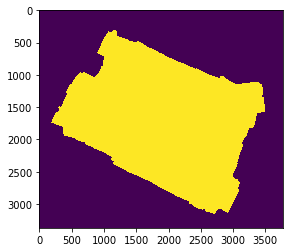

In [12]:
plt.imshow(flir_mask)

### Extract original flight bands to same data extent based on mask

In [13]:
for band in range(flir.shape[0]):
    flir[band][flir_mask==False] = np.nan

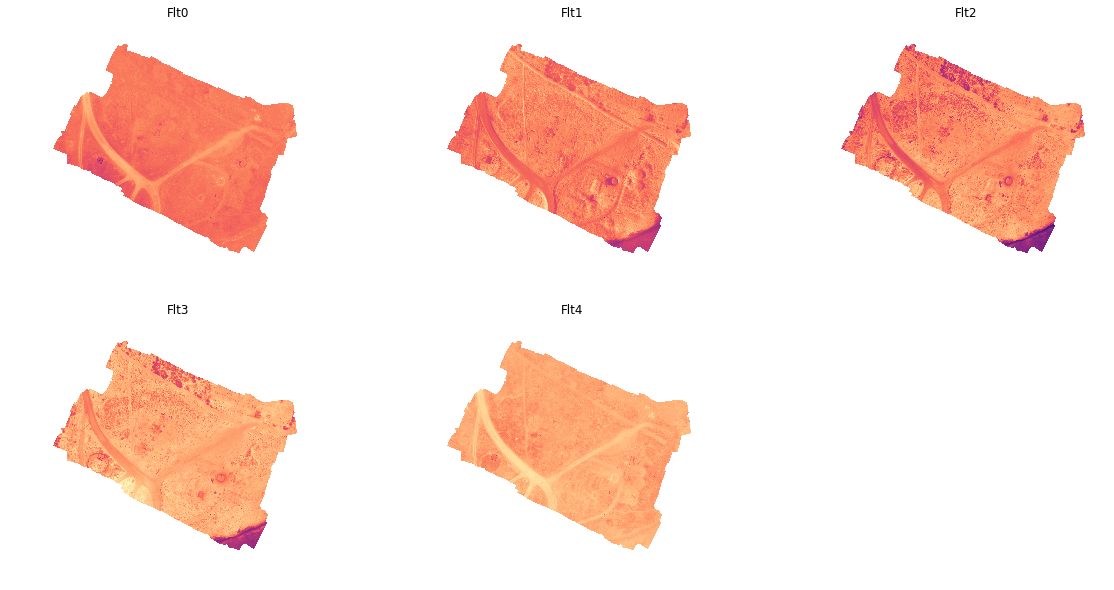

In [14]:
plt.figure(figsize=(20,10))
for band in range(flir.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(flir.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Flt{}'.format(band))
    plt.axis('off')
    plt.imshow(flir[band], cmap='magma')

### Essential summary statistics of each band
#### Note the significant negative skew of each distribution. This is by design. 
#### Ground control targets have extreme outlying LOW thermal radiance, allowing them to be easily identified for geometric corrections. While this is useful for georeferencing, it significantly skews overall distribution of thermal radiance.

In [15]:
def rasterSummary(rast, title): 
    nanmask = np.logical_not(np.isnan(rast))
    
    plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(rast, cmap='magma')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title('{} Histogram'.format(title))
    mini, maxi = np.nanmin(rast), np.nanmax(rast)
    plt.hist(rast[nanmask], bins=50, range=(mini,maxi), color='purple')

    plt.show()
    
    quartiles = np.percentile(rast[nanmask], [25,50,75])
    outstats = [mini, quartiles[0], quartiles[1], quartiles[2], maxi, maxi-mini, 
                quartiles[2]-quartiles[0], np.nanmean(rast), np.nanstd(rast), 
                scipy.stats.skew(rast[nanmask]), scipy.stats.kurtosis(rast[nanmask])]
    statlabel = ['Min.', 'Q1', 'Median', 'Q3', 'Max',
                'Range', 'IQ Range', 'Mean', 'Std. Dev.', 'Skewness', 'Kurtosis']
    outstats = pd.DataFrame({'Value':outstats}, index=statlabel)
    print(outstats)

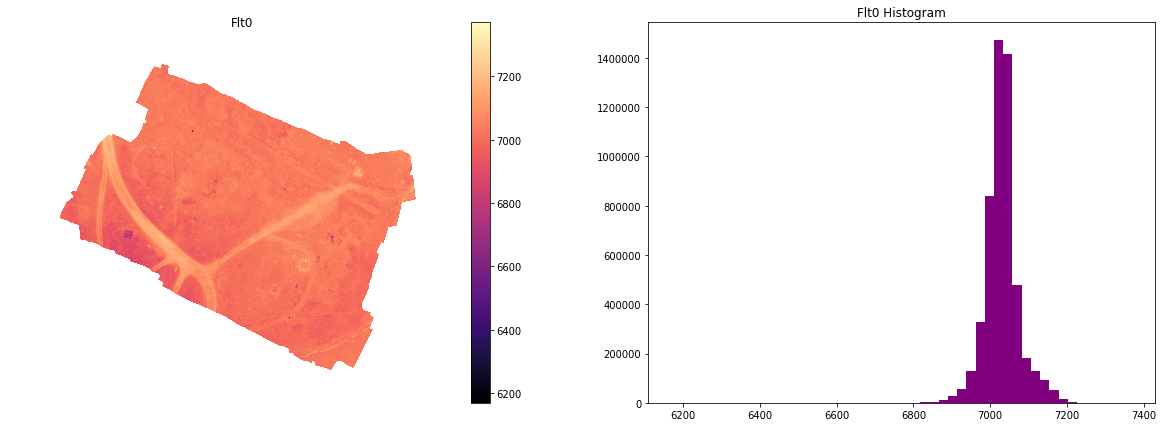

                 Value
Min.       6169.000000
Q1         7009.000000
Median     7031.000000
Q3         7050.000000
Max        7371.000000
Range      1202.000000
IQ Range     41.000000
Mean       7031.420898
Std. Dev.    43.080341
Skewness      0.057475
Kurtosis      5.046139


In [16]:
rasterSummary(flir[0], 'Flt0')

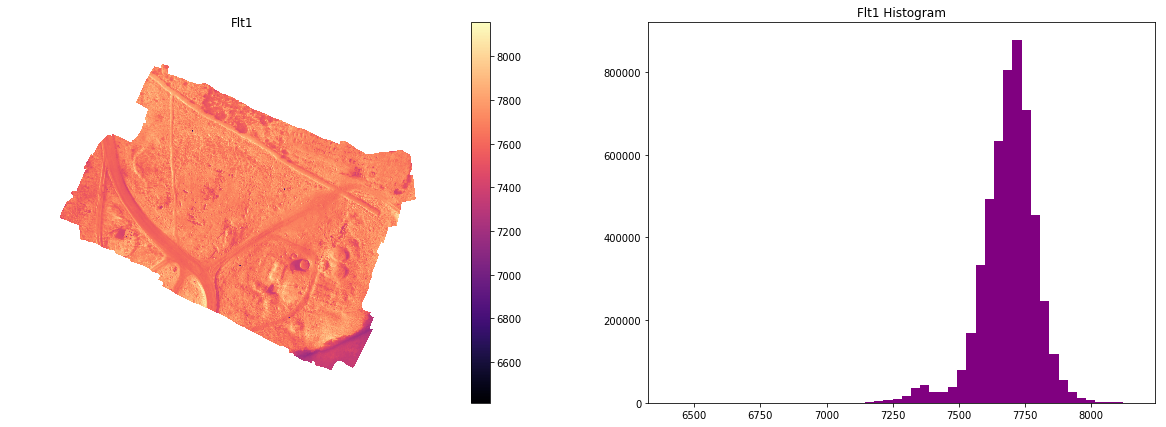

                 Value
Min.       6413.000000
Q1         7635.000000
Median     7698.000000
Q3         7752.000000
Max        8156.000000
Range      1743.000000
IQ Range    117.000000
Mean       7688.152832
Std. Dev.   104.388062
Skewness     -0.904429
Kurtosis      2.785138


In [17]:
rasterSummary(flir[1], 'Flt1')

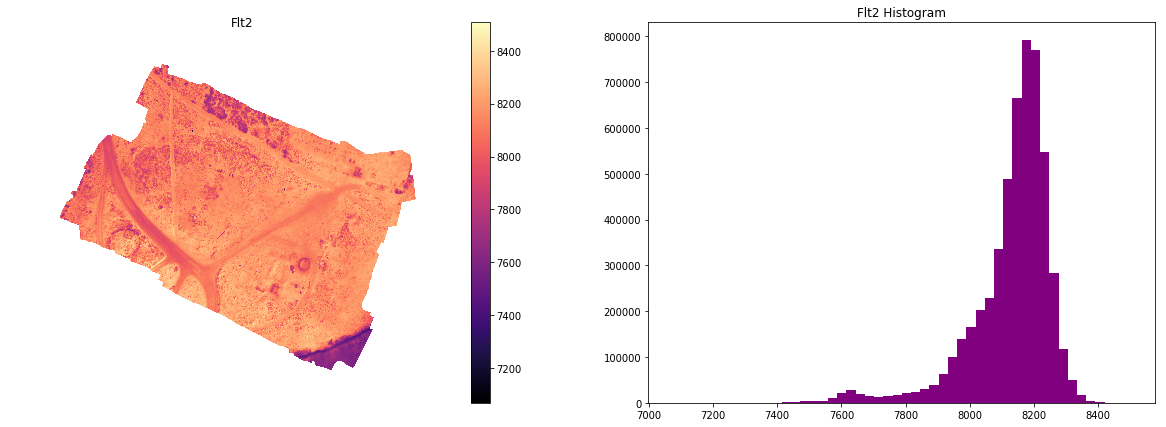

                 Value
Min.       7070.000000
Q1         8090.000000
Median     8161.000000
Q3         8208.000000
Max        8507.000000
Range      1437.000000
IQ Range    118.000000
Mean       8130.557129
Std. Dev.   126.019188
Skewness     -1.911675
Kurtosis      5.126332


In [18]:
rasterSummary(flir[2], 'Flt2')

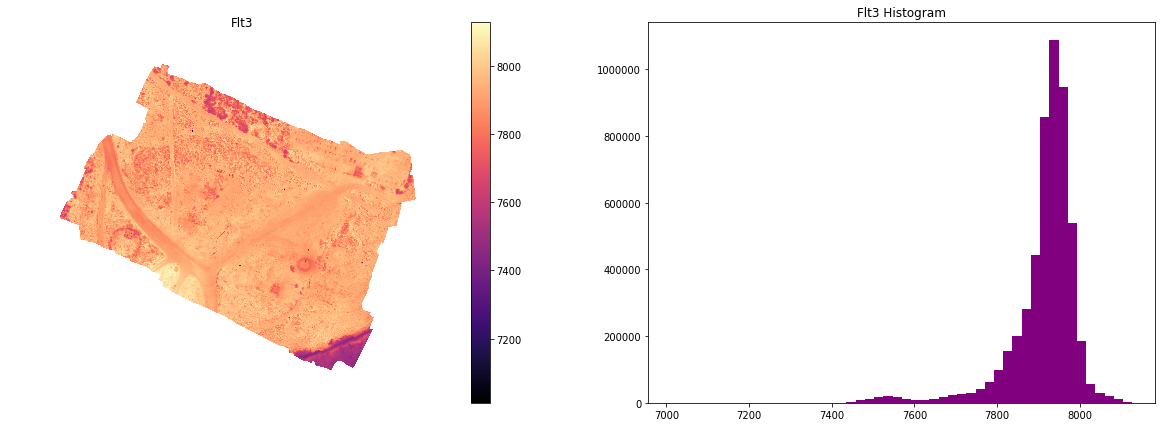

                 Value
Min.       7012.000000
Q1         7896.000000
Median     7932.000000
Q3         7959.000000
Max        8127.000000
Range      1115.000000
IQ Range     63.000000
Mean       7913.887695
Std. Dev.    82.492470
Skewness     -2.431702
Kurtosis      8.505564


In [19]:
rasterSummary(flir[3], 'Flt3')

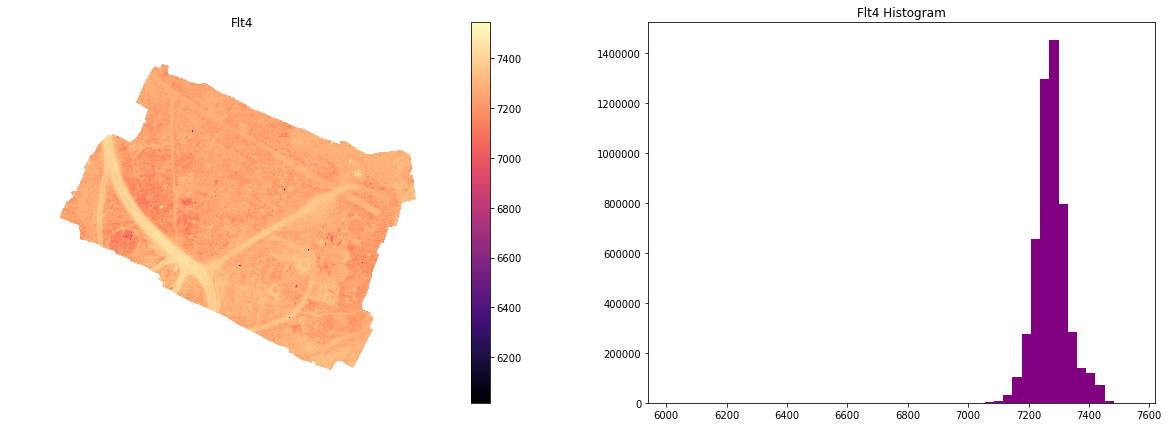

                 Value
Min.       6017.000000
Q1         7245.000000
Median     7274.000000
Q3         7302.000000
Max        7544.000000
Range      1527.000000
IQ Range     57.000000
Mean       7276.127441
Std. Dev.    53.082874
Skewness      0.065980
Kurtosis      5.747276


In [20]:
rasterSummary(flir[4], 'Flt4')

### Trim lower 0.01% of values (removes ground control pixels)
#### Since ground control will be exluded from classification inputs, this offers a better sense of the distribution used in further processing.
#### This is achieved by trimming the lower 0.01% of pixel values, removing almost exclusively ground control pixels from the scene.

In [21]:
def trimvals(band, mask, percentile):
    trimval = np.percentile(band[mask], percentile)
    trimmed = np.copy(band)
    trimmed[trimmed < trimval] = np.nan
    return trimmed

In [22]:
flir_trim = np.array([trimvals(flir[band], flir_mask, 0.01) for band in range(flir.shape[0])])

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


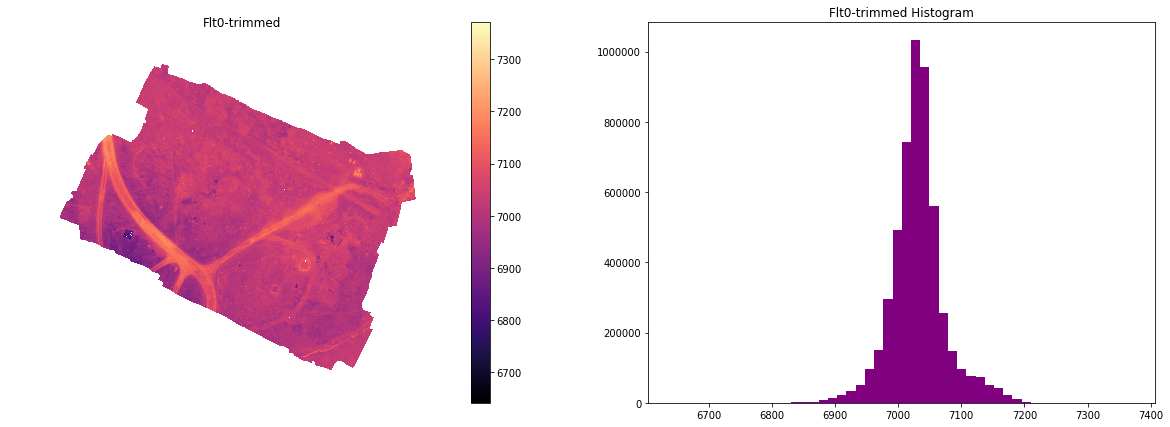

                 Value
Min.       6641.000000
Q1         7009.000000
Median     7031.000000
Q3         7050.000000
Max        7371.000000
Range       730.000000
IQ Range     41.000000
Mean       7031.471191
Std. Dev.    42.767605
Skewness      0.247321
Kurtosis      2.657523


In [23]:
rasterSummary(flir_trim[0], 'Flt0-trimmed')

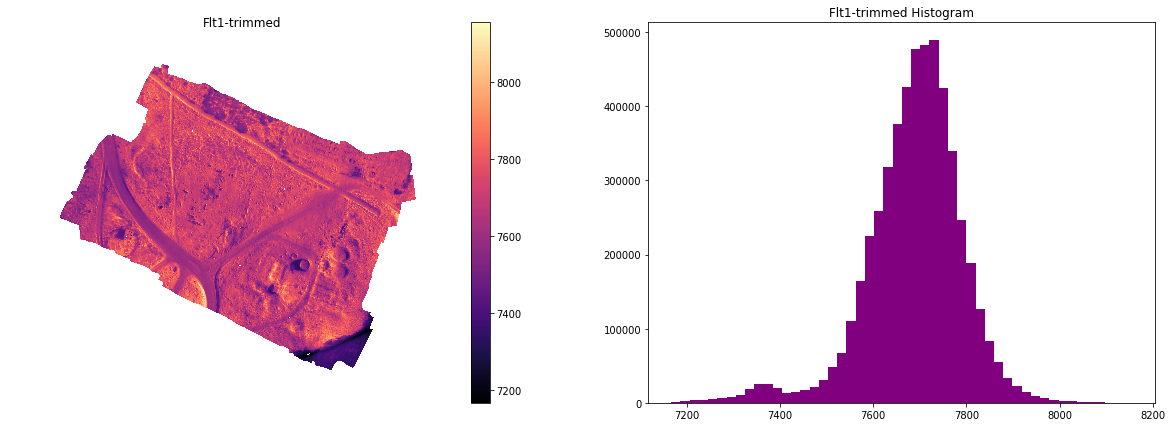

                 Value
Min.       7167.000000
Q1         7635.000000
Median     7698.000000
Q3         7752.000000
Max        8156.000000
Range       989.000000
IQ Range    117.000000
Mean       7688.221191
Std. Dev.   104.163864
Skewness     -0.879160
Kurtosis      2.569026


In [24]:
rasterSummary(flir_trim[1], 'Flt1-trimmed')

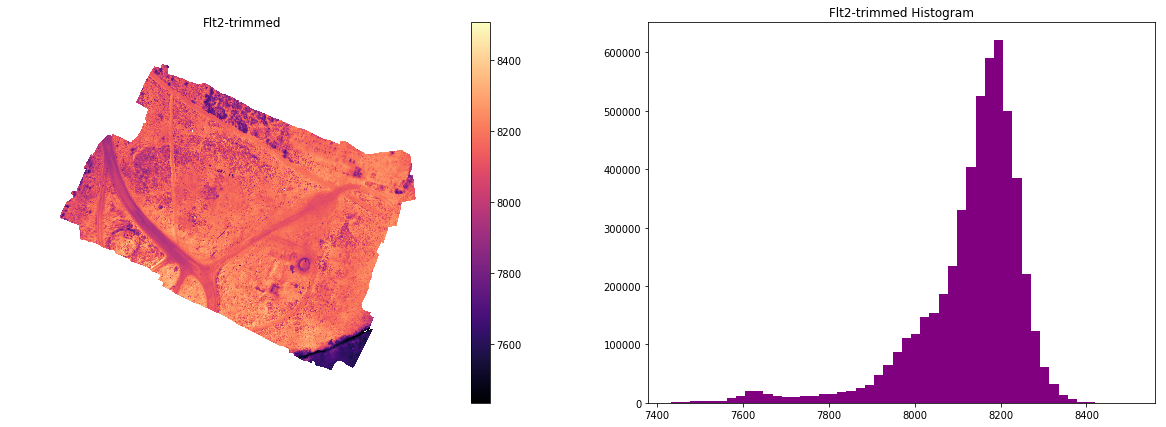

                 Value
Min.       7433.000000
Q1         8090.000000
Median     8161.000000
Q3         8208.000000
Max        8507.000000
Range      1074.000000
IQ Range    118.000000
Mean       8130.630371
Std. Dev.   125.811691
Skewness     -1.902343
Kurtosis      5.058103


In [25]:
rasterSummary(flir_trim[2], 'Flt2-trimmed')

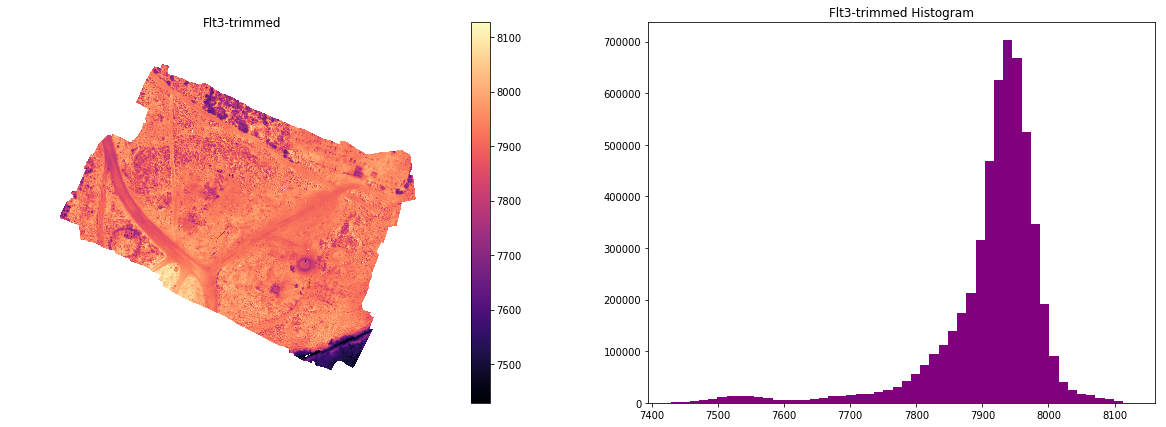

                 Value
Min.       7429.000000
Q1         7896.000000
Median     7932.000000
Q3         7959.000000
Max        8127.000000
Range       698.000000
IQ Range     63.000000
Mean       7913.945801
Std. Dev.    82.299004
Skewness     -2.416055
Kurtosis      8.352972


In [26]:
rasterSummary(flir_trim[3], 'Flt3-trimmed')

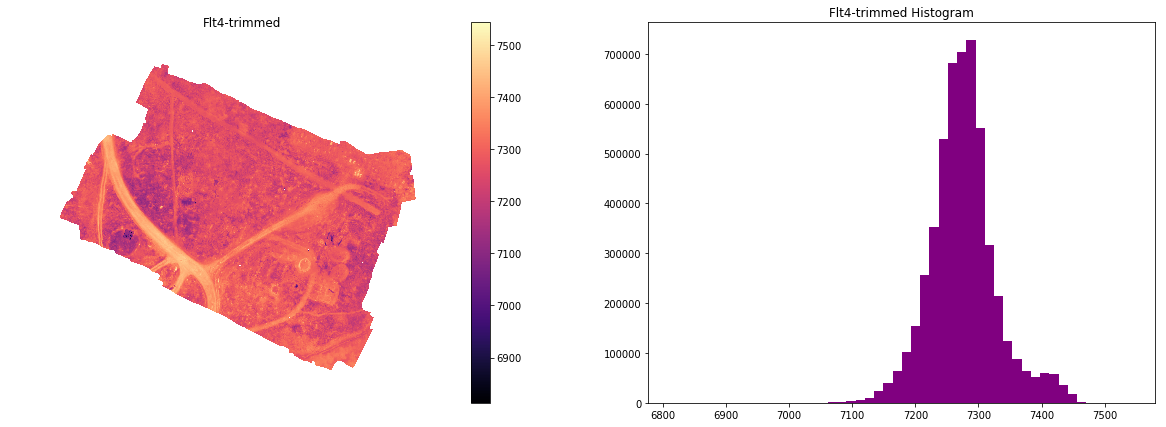

                 Value
Min.       6813.000000
Q1         7245.000000
Median     7274.000000
Q3         7302.000000
Max        7544.000000
Range       731.000000
IQ Range     57.000000
Mean       7276.193848
Std. Dev.    52.614529
Skewness      0.337337
Kurtosis      1.550816


In [27]:
rasterSummary(flir_trim[4], 'Flt4-trimmed')

### Create Pandas DataFrame for further exploration via pairwise plotting of each band

#### Flatten each band into a 1D array and remove null values

In [28]:
flir_flat = np.array([flir[band].reshape((flir[band].shape[0]*flir[band].shape[1])) for 
                      band in range(flir.shape[0])])

In [29]:
flir_flat.shape

(5, 12735230)

In [30]:
flir_df = pd.DataFrame({'Flt'+str(b):flir_flat[b] for b in range(flir_flat.shape[0])})

In [31]:
flir_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [32]:
flir_df = flir_df.dropna().astype(dtype='int32')

In [33]:
flir_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
1165075,7023,7789,7899,7859,7271
1168853,7025,7745,7890,7896,7263
1168854,7021,7773,7904,7863,7265
1168855,7026,7805,7906,7840,7266
1168856,7029,7814,7912,7815,7272


In [34]:
flir_df.describe()

,Flt0,Flt1,Flt2,Flt3,Flt4
count,5.238023e+06,5.238023e+06,5.238023e+06,5.238023e+06,5.238023e+06
mean,7.031419e+03,7.688155e+03,8.130553e+03,7.913883e+03,7.276128e+03
std,4.308034e+01,1.043881e+02,1.260192e+02,8.249250e+01,5.308290e+01
min,6.169000e+03,6.413000e+03,7.070000e+03,7.012000e+03,6.017000e+03
25%,7.009000e+03,7.635000e+03,8.090000e+03,7.896000e+03,7.245000e+03
50%,7.031000e+03,7.698000e+03,8.161000e+03,7.932000e+03,7.274000e+03
75%,7.050000e+03,7.752000e+03,8.208000e+03,7.959000e+03,7.302000e+03
max,7.371000e+03,8.156000e+03,8.507000e+03,8.127000e+03,7.544000e+03


### Pairwise plotting of 5 bands

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


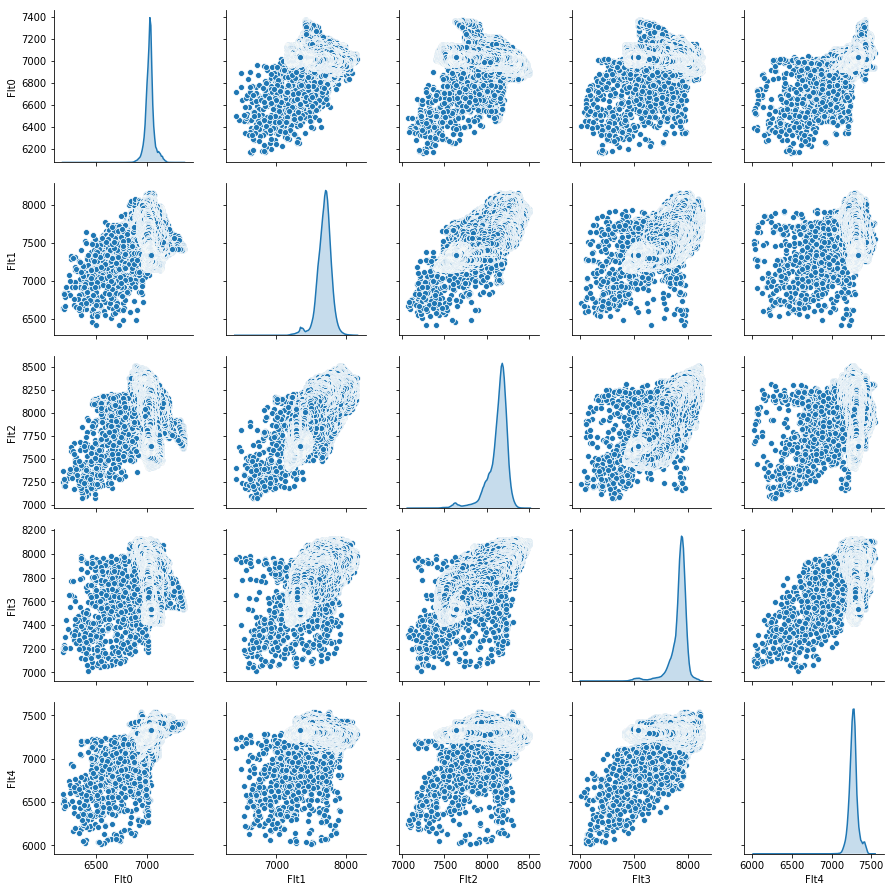

In [35]:
sns.pairplot(flir_df, diag_kind="kde", markers='o')

### Correlatation matrix of 5 input bands
#### Flt0 and Flt4 are positively correlated (cooler times of the day)
#### Flt1, Flt2, and Flt3 are positively correlated (warmer times of the day)
#### (Flt0, Flt4) and (Flt1, Flt2, Flt3) are inversely correlated

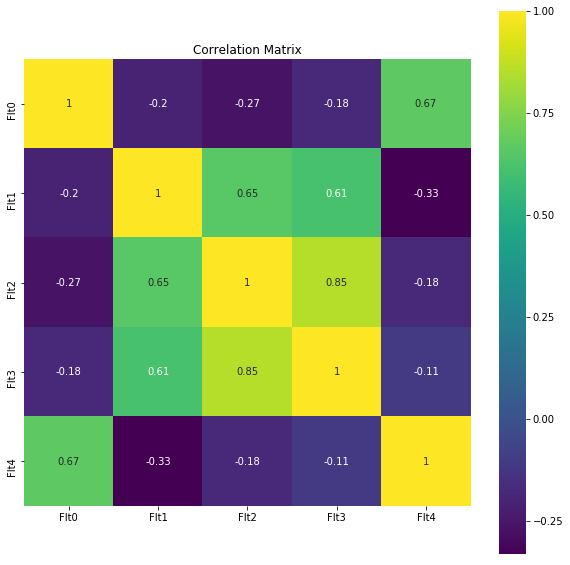

In [36]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(flir_df.corr(), annot=True, square=True, cmap='viridis')